In [1]:
%matplotlib inline
import os
import os.path as osp
import pandas as pd
import numpy as np
import plotnine as pn
import matplotlib.pyplot as plt
from tcre.env import *
from tcre import supervision 
classes = supervision.get_candidate_classes()

In [2]:
res_parts = [
    (osp.join(RESULTS_DATA_DIR, 'modeling-lfs', 'run2'), 'est-strong'),
    (osp.join(RESULTS_DATA_DIR, 'modeling-rnn-strong', 'run3'), 'rnn-strong'),
    (osp.join(RESULTS_DATA_DIR, 'modeling-rnn-weak', 'run4'), 'rnn-weak')
]

### Validate Splits

In [3]:
# Load the candidate ids used in training (+validation, +test) for each modeling strategy and task
df = pd.concat([
    pd.read_json(osp.join(p[0], classes[c].field, 'splits', 'splits.json'), orient='index', typ='series')
    .rename('ids').rename_axis('split').reset_index()
    .assign(task=classes[c].field, grp=p[1])
    for p in res_parts    
    for c in classes
]).reset_index(drop=True)
df.head()

,split,ids,task,grp
0,test,"[55989, 16763, 76236, 13650, 79440, 32790, 685...",inducing_cytokine,est-strong
1,train,"[83383, 79660, 80615, 80033, 83047, 75847, 758...",inducing_cytokine,est-strong
2,val,"[87175, 24618, 60738, 75248, 64539, 75205, 535...",inducing_cytokine,est-strong
3,test,"[159334, 142707, 165697, 179493, 133427, 14644...",secreted_cytokine,est-strong
4,train,"[171932, 172446, 140941, 160270, 173025, 16774...",secreted_cytokine,est-strong


In [4]:
# Verify that across the different modeling strategies, the candidate ids used for validation and test are identical
# (training ids may differ depending on the strategy)
cts = (
    df[df['split'].isin(['test', 'val'])]
    .assign(ids=lambda df: df['ids'].apply(lambda ids: ','.join(map(str, sorted(ids)))))
    .groupby(['task', 'split'])['ids'].nunique()
)
assert (cts == 1).all()
cts

task                           split
inducing_cytokine              test     1
                               val      1
inducing_transcription_factor  test     1
                               val      1
secreted_cytokine              test     1
                               val      1
Name: ids, dtype: int64

In [5]:
del cts
del df

### Load Scores

In [6]:
df = pd.concat([
    pd.read_csv(osp.join(p[0], 'scores.csv')).assign(grp=p[1])
    for p in res_parts
], sort=True)
df.head()

,grp,metric,model,split,task,value
0,est-strong,f1,gbr,validation,inducing_cytokine,0.720000
1,est-strong,accuracy,gbr,validation,inducing_cytokine,0.750000
2,est-strong,precision,gbr,validation,inducing_cytokine,0.818182
3,est-strong,recall,gbr,validation,inducing_cytokine,0.642857
4,est-strong,roc_auc,gbr,validation,inducing_cytokine,0.742347


In [7]:
df.groupby(['task', 'grp', 'split'])['metric'].nunique().unstack()

split                                     test  training  validation
task                          grp                                   
inducing_cytokine             est-strong     6         6           6
                              rnn-strong    11        11          11
                              rnn-weak      11        11          11
inducing_transcription_factor est-strong     6         6           6
                              rnn-strong    11        11          11
                              rnn-weak      11        11          11
secreted_cytokine             est-strong     6         6           6
                              rnn-strong    11        11          11
                              rnn-weak      11        11          11

In [10]:
def get_plot(df, metric, rand_baseline=.5, pos_baseline=.66):
    return (
        pn.ggplot(
            df
                .pipe(lambda df: df[df['metric'] == metric])
                .assign(model=lambda df: pd.Categorical(
                    df['model'], ordered=True, 
                    # Average across tasks
                    categories=df[df['split'] == 'test'].groupby(['metric', 'model'])['value'].mean().loc[metric].sort_values().index
                ))
                .assign(type=lambda df: df['grp'].map({
                    'rnn-weak': 'RNN (Weak)',
                    'rnn-strong': 'RNN (Strong)',
                    'est-strong': 'Sentence-Level Models'
                }))
                .assign(label=lambda df: df['value'].apply(lambda v: f'{100*v:.1f}'))
            ,
            pn.aes(x='model', y='value', fill='type', label='label')
        ) + 
        pn.geom_bar(stat='identity', position='dodge', alpha=.5) +
        pn.geom_text(va='top', size=10) + 
        pn.facet_grid('task ~ split') +
        pn.coord_cartesian(ylim = (.45, 1)) + 
        pn.geom_hline(yintercept=pos_baseline, linetype='solid') + 
        pn.geom_hline(yintercept=rand_baseline, linetype='dashed') +
        pn.theme_bw() + 
        pn.theme(figure_size=(16, 8))
    )

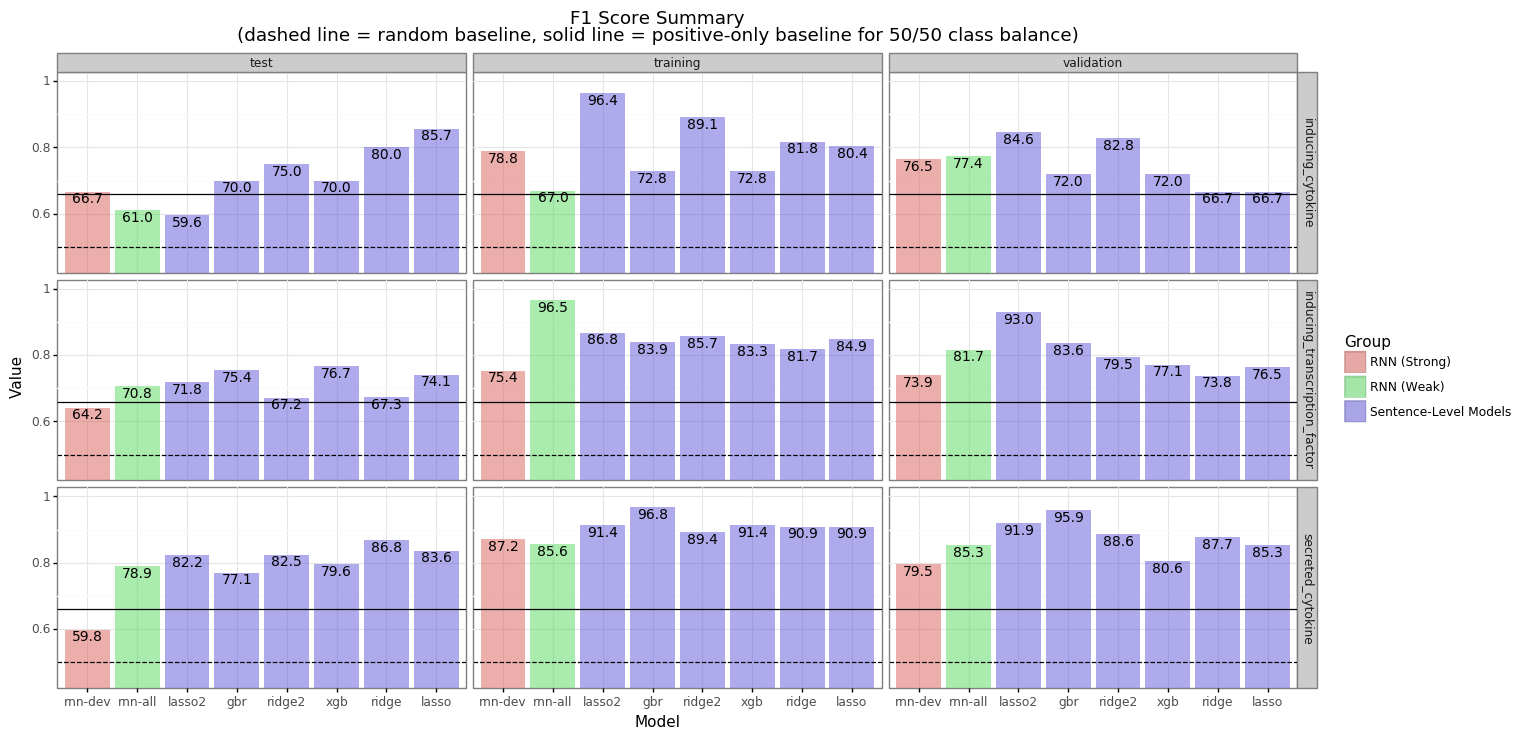

<ggplot: (-9223363248885220201)>

In [11]:
get_plot(df, 'f1') + pn.labs(
    x='Model', y='Value', fill='Group',
    title='F1 Score Summary\n(dashed line = random baseline, solid line = positive-only baseline for 50/50 class balance)'
)

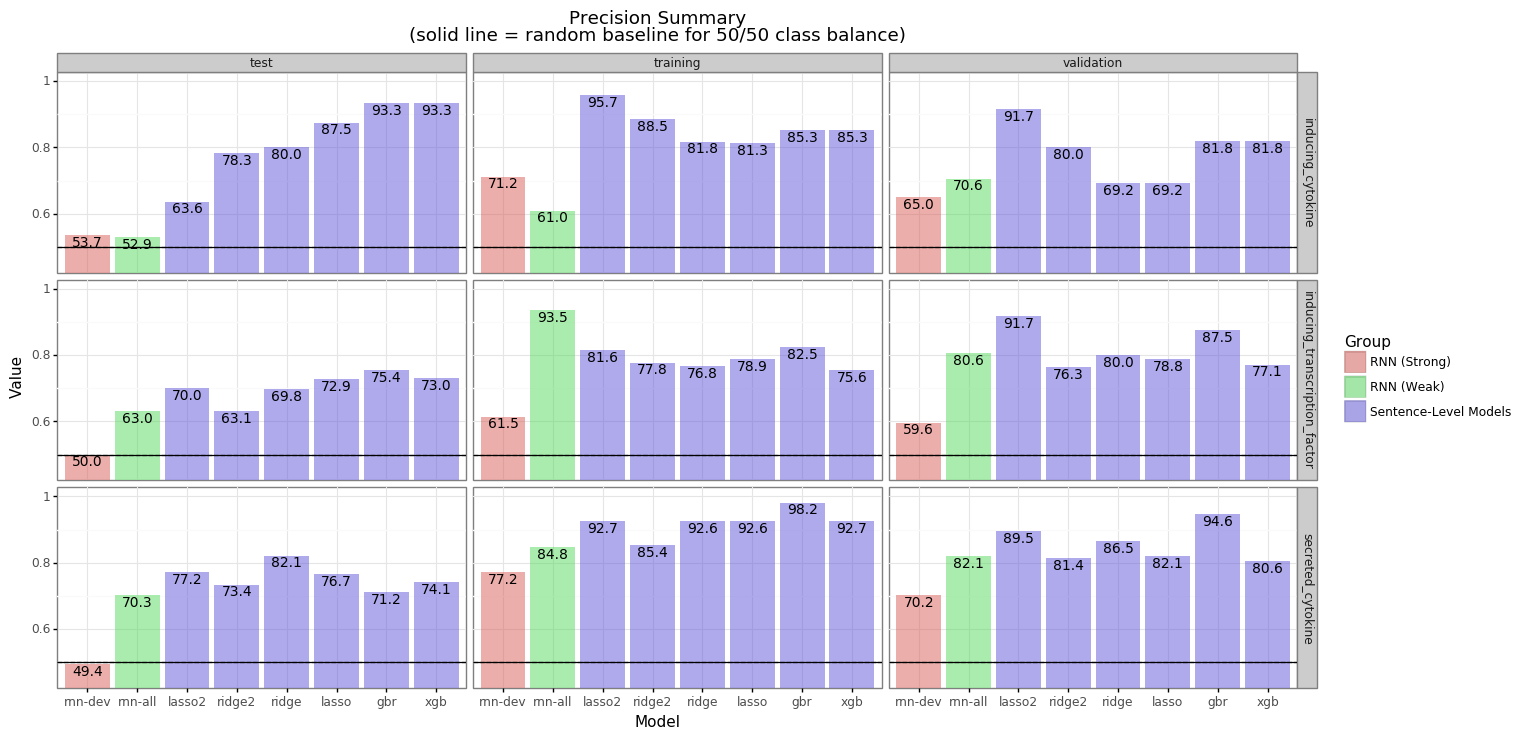

<ggplot: (8787865162472)>

In [13]:
get_plot(df, 'precision', pos_baseline=.5) + pn.labs(
    x='Model', y='Value', fill='Group',
    title='Precision Summary\n(solid line = random baseline for 50/50 class balance)'
)

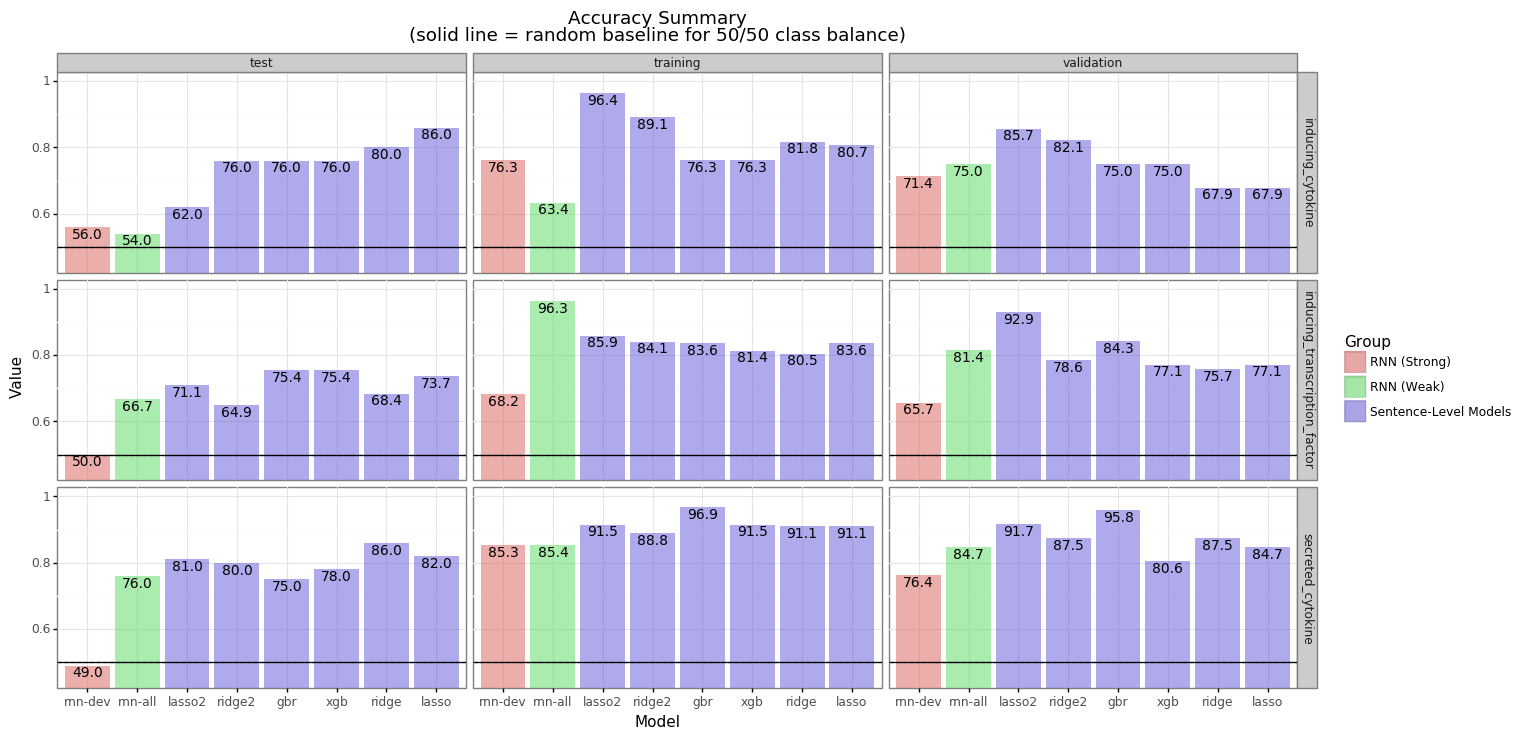

<ggplot: (-9223363248990700344)>

In [14]:
get_plot(df, 'accuracy', pos_baseline=.5) + pn.labs(
    x='Model', y='Value', fill='Group',
    title='Accuracy Summary\n(solid line = random baseline for 50/50 class balance)'
)